In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 


from xgboost import XGBRegressor

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

### **Time Series Pattern**

1. Exponential Trend (Kurva Keatas secara signifikan)
2. Linear Trend (Garis keatas)
3. Seasonal Pattern (terdapat kesamaan garis antar satu sisi dengan sisi lainnya)
4. Seasonal pattern with linear growth (Ada pola yang sama antar data timeseries dengan arah ke bawah atau keatas)

In [3]:
df = pd.read_csv("megawatt_energy_consumption.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


### **Data Prep for Time Series**

1. Buat datetime menjadi index & visual
2. Pisah train dan test dengan datetime query
3. Analisis sederhanda

#### Datetime column ke index

In [4]:
# Set dt into index
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

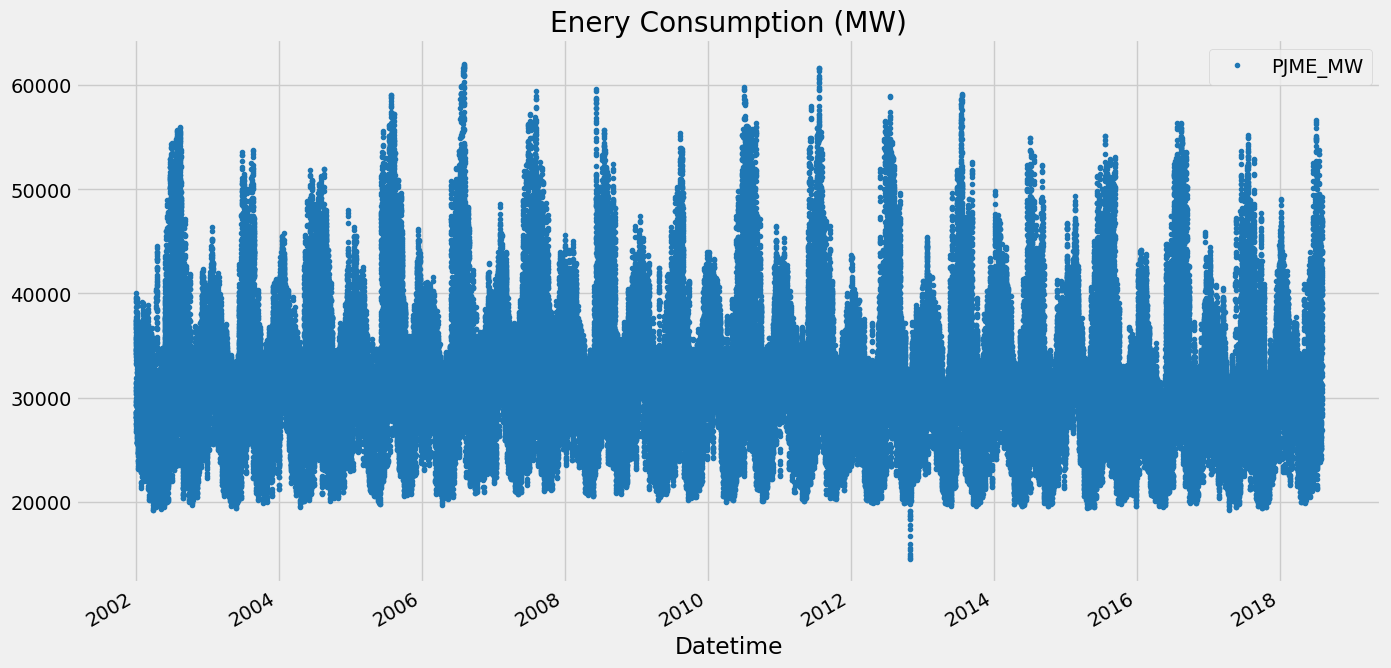

In [5]:
# visualize

df.plot(style='.', 
        figsize=(15,8),
        color=color_pal[0],
        title="Enery Consumption (MW)")

plt.show()

#### Train / Test Split

In [6]:
train   = df.loc[df.index < '01-01-2015']
test    = df.loc[df.index >= '01-01-2015']

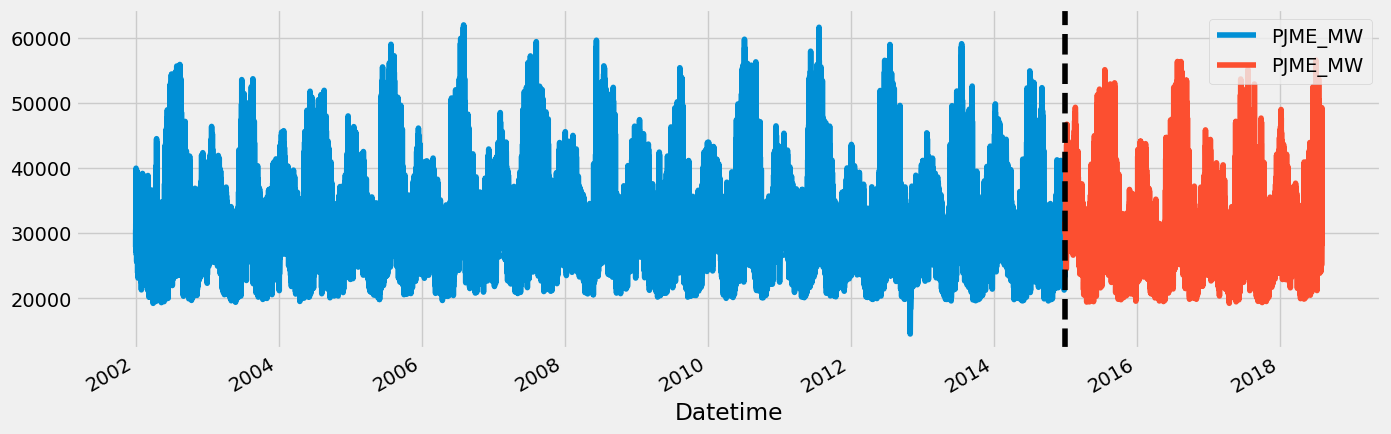

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
plt.show()

#### Analisis Sederhana

<Axes: xlabel='Datetime'>

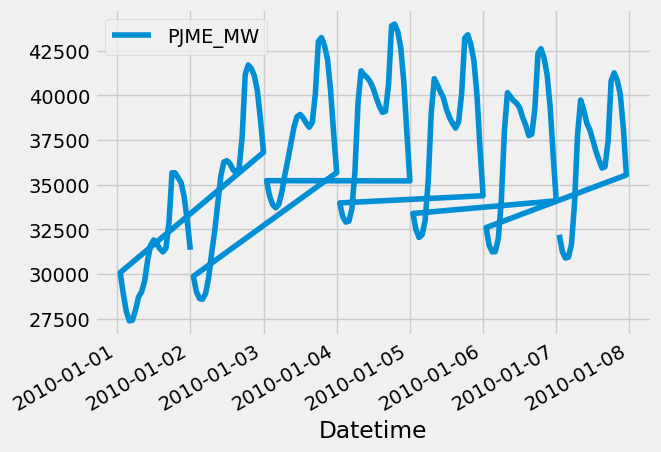

In [8]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot()

#### **Feature Creation**

In [9]:
def create_features(df):
    ''' 
    Create Feature Based on TimeSeries Index
    '''
    df = df.copy()
    df['hour']      = df.index.hour 
    df['dayofweek'] = df.index.day_of_week
    df['quarter']   = df.index.quarter
    df['month']     = df.index.month
    df['year']      = df.index.year 
    df['dayofyear'] = df.index.day_of_year
    return df


In [10]:
df = create_features(df)
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


#### Visualize Feature / Target Relationship

##### Hour

<Axes: xlabel='hour', ylabel='PJME_MW'>

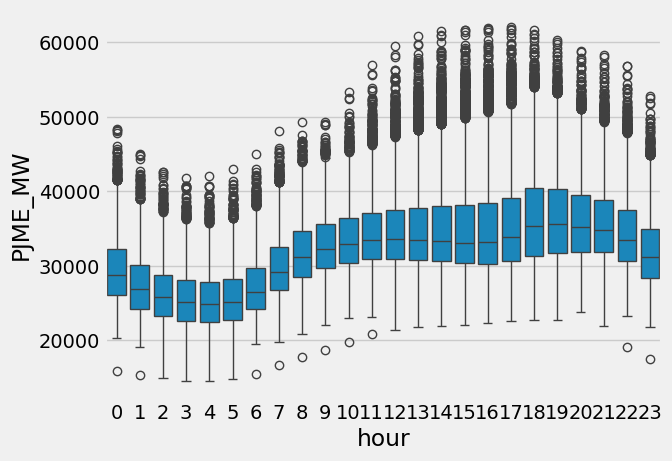

In [11]:
sns.boxplot(data=df, x='hour', y='PJME_MW')

<Axes: xlabel='dayofweek', ylabel='PJME_MW'>

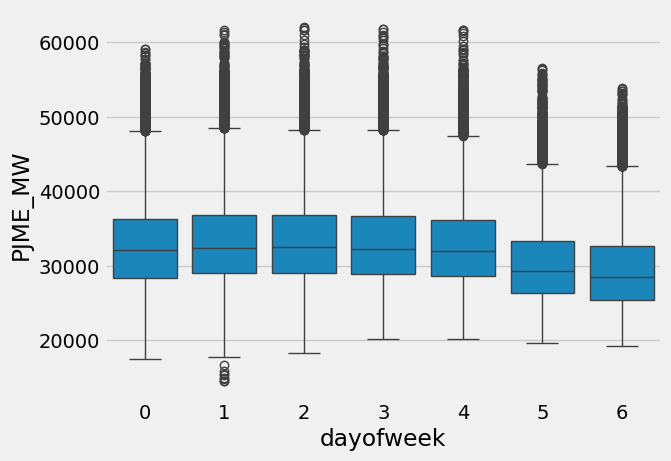

In [12]:
sns.boxplot(data=df, x='dayofweek', y='PJME_MW')

<Axes: xlabel='month', ylabel='PJME_MW'>

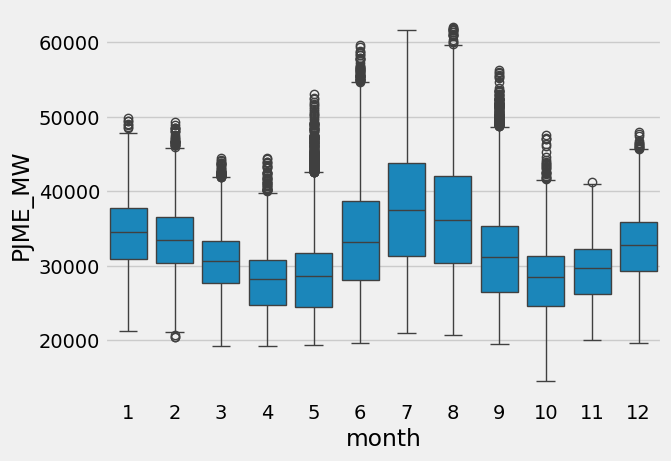

In [13]:
sns.boxplot(data=df, x='month', y='PJME_MW')

<Axes: xlabel='year', ylabel='PJME_MW'>

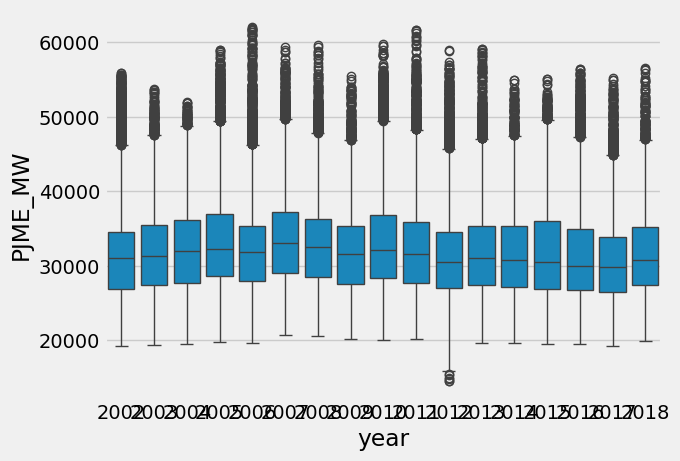

In [14]:
sns.boxplot(data=df, x='year', y='PJME_MW')

### **Modelling**

1. Apply Feature creation to train - test data
2. Split data into features and target

In [15]:
train = create_features(train)
test = create_features(test)

In [16]:
features = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
target = 'PJME_MW'

In [17]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

#### Fit Model into data

In [18]:
reg = XGBRegressor(n_estimators=1000,
                   early_stopping_rounds=50,
                   learning_rate = 0.01)

In [19]:
reg.fit(X_train, y_train,
        eval_set = [(X_train,y_train),(X_test, y_test)],
        verbose=100
        )

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

### **Feature Importance**

In [20]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns = ['importance'])

In [21]:
fi.sort_values('importance', ascending=False)

,importance
hour,0.463878
month,0.203161
dayofweek,0.162005
dayofyear,0.118251
quarter,0.028881
year,0.023824


<Axes: title={'center': 'Feature Importance'}>

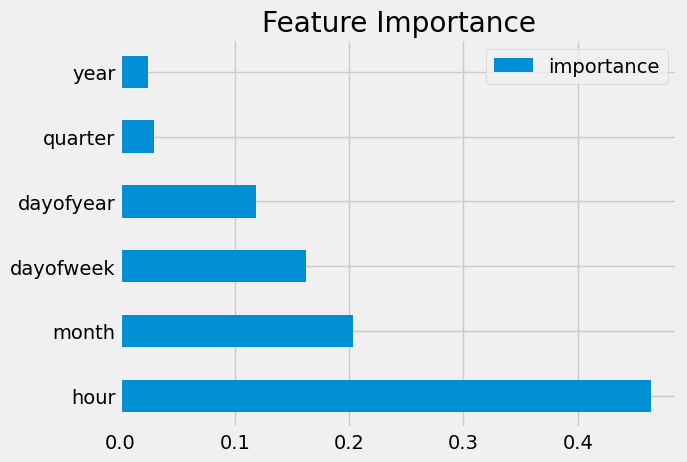

In [22]:
fi.sort_values('importance', ascending=False).plot(kind='barh', title='Feature Importance')

### **Forecast**

In [23]:
test['prediction'] = reg.predict(X_test)

#### Merge test data into original df 

-> for visualizing the evaluation process

In [24]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

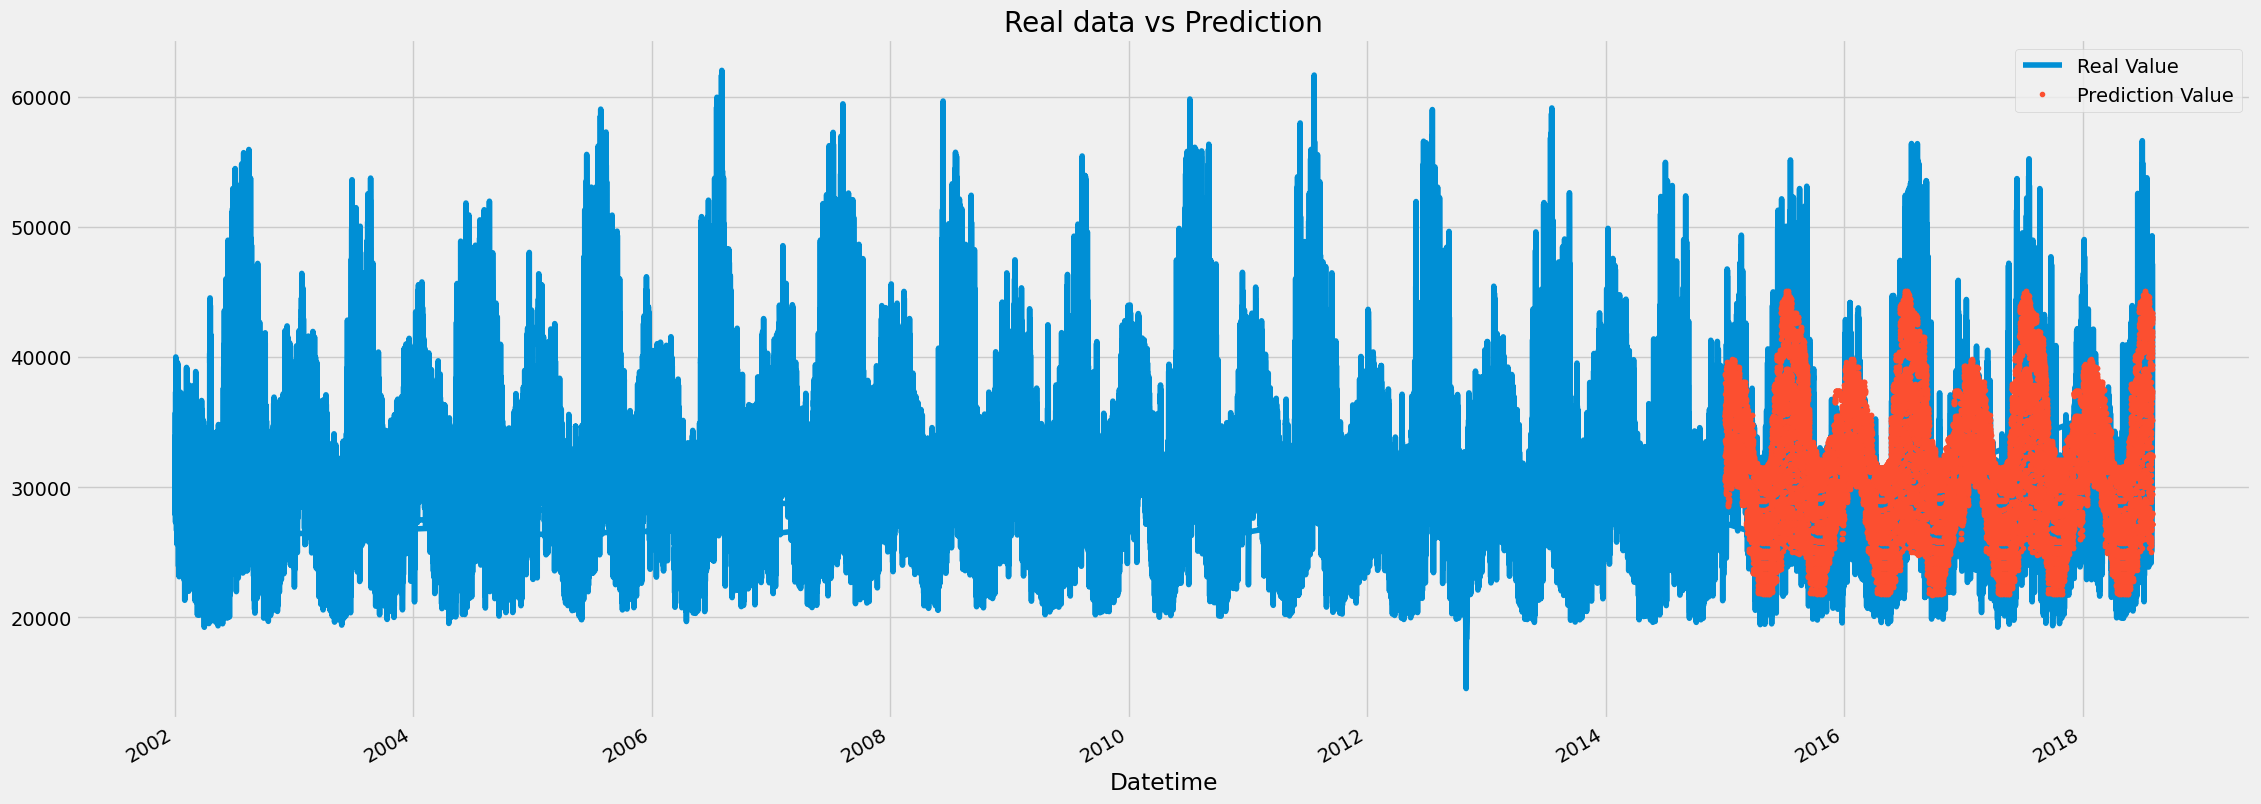

In [25]:
ax = df[['PJME_MW']].plot(figsize=(25,10))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Real Value', 'Prediction Value'])
ax.set_title('Real data vs Prediction')
plt.show()

<Axes: title={'center': 'Week Of Data'}, xlabel='Datetime'>

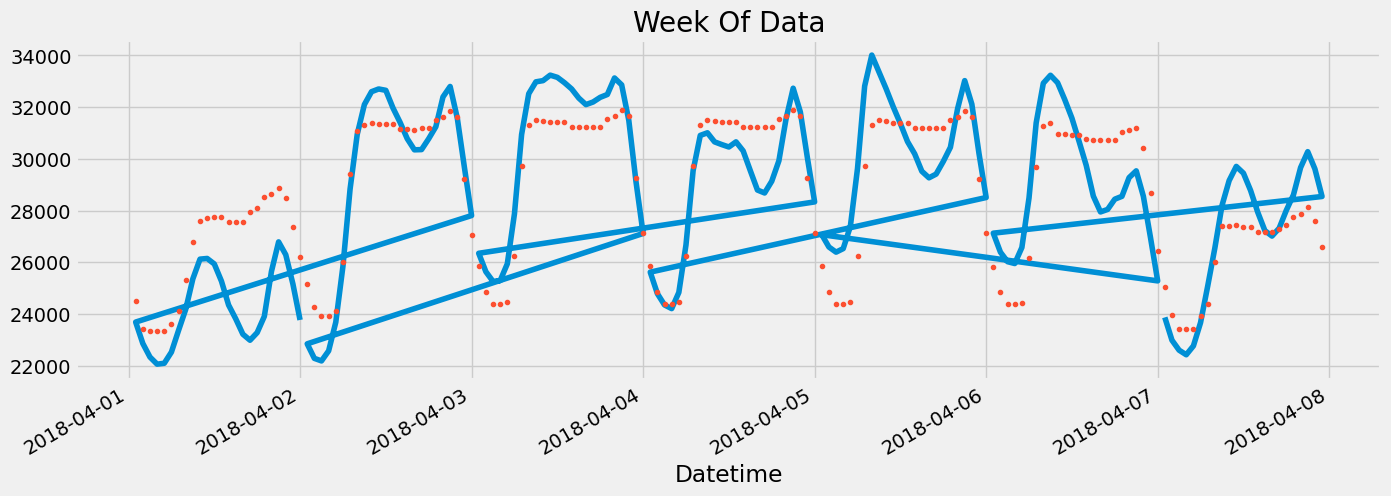

In [26]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')

df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')

### **Evaluation**

In [ ]:
#MAE Score
from sklearn.metrics import mean_squared_error

score = mean_squared_error(test['PJME_MW'], test['prediction'])
print(f"MSE Score : {score:0.2f}")

MSE Score : 13995306.80


In [31]:
# Raw Evaluation
test['error'] = np.abs(test[target] - test['prediction'])
test['date']  = test.index.date 
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(20) 

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
2018-01-06    10407.698161
2015-02-20    10143.611491
2017-05-19     9495.122640
2016-07-04     9440.610596
2016-07-23     9362.332682
2018-01-07     9315.937988
2015-02-16     9288.292236
2016-08-11     9013.506266
2017-12-31     9004.714274
2015-02-21     8843.263021
2015-09-09     8829.495605
2018-01-05     8608.295898
2016-08-15     8591.602620
2015-02-15     8381.954997
2016-08-16     8272.506836
Name: error, dtype: float64

In [32]:
test.groupby(['date'])['error'].mean().sort_values().head(20) 

date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
2015-10-28    459.086426
2016-06-03    467.453532
2018-02-06    477.327718
2016-08-08    496.441406
2016-12-12    553.641357
2017-12-08    555.198405
2018-04-19    581.366943
2016-12-29    586.855387
2016-12-13    590.555990
2016-03-20    591.327555
2016-01-12    603.595296
2016-07-13    604.466797
2018-05-16    607.862223
2017-04-01    608.491292
2017-08-12    611.629069
Name: error, dtype: float64